**Sports topology: exploration of word embeddings**

In this research we are aimining to explore how Russian sports names are organized and related within the semantic space.

In [54]:
# Import necessary libraries

import pandas as pd
import numpy as np
import torch

from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from itertools import combinations
from scipy.spatial.distance import cosine
from collections import defaultdict
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from adjustText import adjust_text

import random

We will be using contextualized embeddings, provided by a model with the following characteristics:

Model: DeepPavlov/rubert-base-cased
Monolingual Russian BERT (2019)
cased, vocab size = 120K, parameters = 180M
Built using Subword NMT on Russian Wiki (80%) and news data (20%)
Embeddings of 768 dimensions

In [55]:
# Load RuBERT model and tokenizer
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states = True)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Creating lists of sport names**

We manually collected 100 sports names in Russian and labeled them into one of 13 categories (e.g. combat, animal, extreme, water sports) based on our understanding of these sports logic, mechanics and scoring system.

Our hypothesis for this study is that, in a semantic space, sports that have similar gameplay mechanics, rules, and scoring systems will be positioned closely, despite differences in equipment.

In [31]:
# Team sports that usually involve goal scoring system
ball_team_sports = [
    'футбол', 'баскетбол', 'волейбол', 'регби', 'американский футбол', 'бейсбол',
    'хоккей с мячом', 'хоккей', 'водное поло', 'крикет', 'лакросс', 'гандбол'
    #,'софтбол', 'флорбол', "пейнтбол" 'пляжный футбол',
    ]

# Motor sports (auto and moto)
motor_sports = ['автогонки', 'ралли', 'картинг', 'мотоспорт', 'мотокросс', 'дрифт', 'драг-рейсинг']

# Combat Sports, Martial Arts
combat_sports = [
    'кунг-фу', 'бокс', 'дзюдо', 'карате', 'тайский бокс', 'тхэквондо',
    'сумо', 'джиу-джитсу', 'айкидо', 'самбо', 'греко-римская борьба',
    'вольная борьба', 'рукопашный бой'
    #'ММА',
    ]

# Gymnastics and acrobatics
gymnastics_and_acrobatics = [
    'художественная гимнастика', 'спортивная гимнастика', 'прыжки на батуте', 'фигурное катание',
    'синхронное плавание'
    #'танцы на льду', 'акробатика' 'брейк-данс'
    ]

# Athletics
athletics_and_running = [
    '110 метров с барьерами', 'марафонский бег', 'полумарафон', 'триатлон',
    'ультрамарафон', 'веломарафон', 'шоссейный бег'
    #, 'бег по пересечённой местности'
    ]

# Water sports
water_sports = [
    'академическая гребля', 'плавание на открытой воде', 'гребной слалом', 'прыжки в воду'
    # 'гребля на байдарках и каноэ', 'аквабайк',
    ]

# Extreme sports
extreme_sports = [
    'параглайдинг', 'дельтапланеризм', 'бейсджампинг', 'маунтинбайк', 'каякинг', 'сёрфинг', 'кайтсерфинг', 'фридайвинг', 'рафтинг',
    'виндсерфинг', 'дайвинг'
    ]

# Snow sports
snow_sports = [
    'лыжи', 'биатлон', 'сноуборд', 'горные лыжи', 'прыжки на лыжах с трамплина', 'бобслей',
    'скелетон', 'санный спорт']

# Strength and fitness
strength_sports = ['пауэрлифтинг', 'армрестлинг', 'бодибилдинг'
                  # , 'толкание ядра'
]

# Mind Sports
mind_sports = ["шахматы", "шашки", "покер", "бридж"
    #"спортивное программирование" "киберспорт"
    ]

# Racket games
racket_sports = ['пинг-понг', 'настольный теннис', 'теннис', 'бадминтон', "падел-теннис", "сквош"]

# Sports involving animals
animal_sports = ['собачьи бега', "верблюжьи бега", "тараканьи бега", 'гонки на собачьих упряжках', 'конкур', "конные скачки"]
#"коррида", "петушиные бои"

# Precision sports
precision_sports = [
    'гольф', 'стрельба из лука', 'стендовая стрельба', 'бильярд', 'дартс',
    'метание молота', 'метание копья', 'метание ядра', 'кёрлинг', 'фехтование']

**Let's get the embeddings**

First, we are defining functions for getting embeddings for our sports names and summarize them across several hidden layers. 

In [32]:
def process_with_BERT(tokenized_text):

  # we have to map the tokens to BERT vocabulary indices
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  # BERT expects either 1 or 2 sentences. If we give only one sentence,
  # we identify its tokens with 1s.
  segments_ids = [1] * len(tokenized_text)
  # Convert inputs to PyTorch tensors

  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])

  # Run the text through BERT, and collect all of the hidden states produced
  # from all 12 layers.
  with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on
    # how it's  configured in the `from_pretrained` call earlier. In this case,
    # becase we set `output_hidden_states = True`, the third item will be the
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_layers = outputs[2]

  return hidden_layers

def rearrange_BERT_object(hidden_layers):
  token_embeddings = torch.stack(hidden_layers, dim=0)
  token_embeddings = torch.squeeze(token_embeddings, dim=1)
  token_embeddings = token_embeddings.permute(1,0,2)
  return token_embeddings

def embeddings_by_sum(hidden_layers):
  # we rearrange the hidden layers so that we can more easily iterate over tokens
  token_embeddings = rearrange_BERT_object(hidden_layers)
  token_vecs_sum = []

  for token in token_embeddings:
    # 'token' is a [12 x 768] tensor
    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    # Use 'sum_vec' to represent token.
    token_vecs_sum.append(sum_vec)

  return token_vecs_sum

As embeddings in RuBERT are contextualized, the model shows better performance on giving accurate embeddings for words used within contexts. That is why we are using a sentence "Спорт, такой как " + word + ", требует особых навыков" (Sport such as SPORT_NAME requires special skills) that is supposed to help us disambiguate meanings for polysemic words.

In [33]:
# Categories in a form of dictionary
categories = {
    'Ball Team': ball_team_sports,
    'Motor': motor_sports,
    'Combat': combat_sports,
    'Gymnastics': gymnastics_and_acrobatics,
    'Athletics': athletics_and_running,
    'Water': water_sports,
    'Extreme': extreme_sports,
    'Snow': snow_sports,
    'Strength': strength_sports,
    'Mind': mind_sports,
    'Racket': racket_sports,
    'Animal': animal_sports,
    'Precision': precision_sports,
    #'Throwing': throwing_sports,
    #'Non-competitive': non_competitive_trainings,
    #'Leagues': ligues_and_competitions
}

# Combining sport group names into one list
all_sports = sum(categories.values(), [])

# Empty lists for future embeddings and labels
embeddings, valid_words, labels = [], [], []

for word in all_sports:
    # Construct the marked text for BERT input
    marked_text = "[CLS] Спорт, такой как " + word + ", требует особых навыков [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    # Get the length of the word tokens in the context of the marked text
    length = len(tokenizer.tokenize(word))
    hidden_layers = process_with_BERT(tokenized_text)

    # Append the word to valid words list
    valid_words.append(word)

    # Process embeddings with BERT
    try:
      # Get the token embeddings by summing hidden layers
      embeddings_sum = embeddings_by_sum(hidden_layers)

    # Calculate the mean of the token embeddings for the specific word tokens
      embedding = torch.mean(torch.stack(embeddings_sum[-(length + 5):-5]), dim=0)

    # Append the processed embedding
      embeddings.append(embedding)

    # Assign a label based on the category the word belongs to
      label = next((category for category, words in categories.items() if word in words), None)
      labels.append(label)

    except Exception as e:
      print(f"Error processing '{word}': {e}")

# Convert embeddings to a numpy array for further processing
embeddings = np.array([emb.detach().numpy() for emb in embeddings])

In [34]:
print("Dimensionality of embeddings:", embeddings.shape[1])

Dimensionality of embeddings: 768


**Calculating cosine similarity in the groups**

Now, let's look at how close are the embeddings within our groups on average. We are using cosine similarity for each pair of vectors within a group and then get means of the similarities within the group.

In [35]:
def calculate_cosine_similarity(embeddings, labels):
  # Grouping embeddings by label
  grouped_vectors = defaultdict(list)
  for label, vector in zip(labels, embeddings):
      grouped_vectors[label].append(vector)

  # Average cosine similarity by group
  average_similarities_by_group = {}
  for label, vectors in grouped_vectors.items():
      cosine_similarities = []

      # Ignoring groups with less than 2 elements
      if len(vectors) < 2:
          average_similarities_by_group[label] = 1
          continue

      # Cosine similarity by pair
      for vec1, vec2 in combinations(vectors, 2):
          similarity = 1 - cosine(vec1, vec2)
          cosine_similarities.append(similarity)

      # Average similarity
      average_similarity = np.mean(cosine_similarities)
      average_similarities_by_group[label] = average_similarity

  # Sorting average_similarities_by_group by similarity values
  sorted_groups = sorted(average_similarities_by_group.items(), key=lambda x: x[1], reverse=True)

  print("Average cosine similarity by group:")
  print()
  for label, avg_similarity in sorted_groups:
      print(f"{label}, {avg_similarity:.2f}")

In [36]:
calculate_cosine_similarity(embeddings, labels)

Average cosine similarity by group:

Strength, 0.88
Water, 0.82
Extreme, 0.81
Athletics, 0.81
Ball Team, 0.81
Gymnastics, 0.80
Snow, 0.78
Motor, 0.77
Animal, 0.77
Combat, 0.76
Mind, 0.74
Precision, 0.74
Racket, 0.72


Cosine similarity seems to be high, the lowest score is 0.72. The most similar group is Strength Sports with the score of 0.88.

Now we want to check what would be the random group mean similarity. We keep the original embeddings the same, but the labels (categories like "Ball Team", "Combat", etc.) are shuffled randomly. This means that each embedding is assigned a random label instead of its true label. By shuffling the labels, we simulate the scenario where there is no inherent grouping or structure in the data. We then compute the mean cosine similarity of these randomly assigned groups to see what the expected similarity would be if there were no real categories. And it is lower than of most our groups, on the level of Racket Sports.

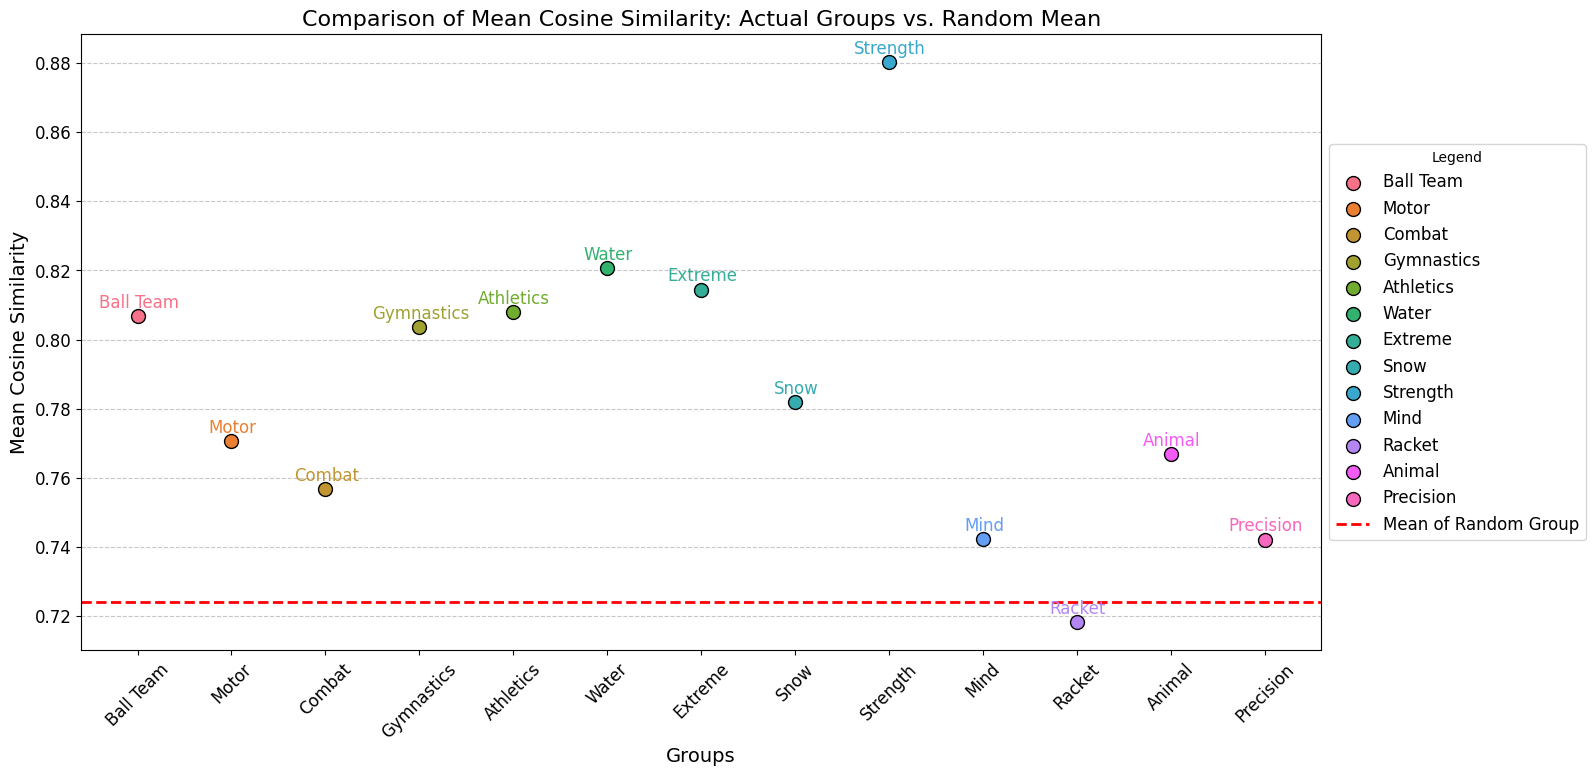

In [37]:
def calculate_mean_cosine_similarity_by_group(embeddings, labels):
    grouped_vectors = defaultdict(list)
    for label, vector in zip(labels, embeddings):
        grouped_vectors[label].append(vector)

    mean_similarities_by_group = {}
    for label, vectors in grouped_vectors.items():
        if len(vectors) < 2:
            continue
        cosine_similarities = [1 - cosine(vec1, vec2) for vec1, vec2 in combinations(vectors, 2)]
        mean_similarity = np.mean(cosine_similarities)
        mean_similarities_by_group[label] = mean_similarity

    return mean_similarities_by_group

def calculate_random_mean_similarity(embeddings, labels, n_shuffles=1000):
    random_mean_similarities = []

    for _ in range(n_shuffles):
        shuffled_labels = random.sample(labels, len(labels))
        mean_similarity = calculate_mean_cosine_similarity_by_group(embeddings, shuffled_labels)
        random_mean_similarities.append(np.mean(list(mean_similarity.values())))

    return random_mean_similarities

# Calculate mean cosine similarity for each actual group
actual_mean_similarities = calculate_mean_cosine_similarity_by_group(embeddings, labels)

# Calculate mean cosine similarities for random groups
random_mean_similarities = calculate_random_mean_similarity(embeddings, labels)

# Prepare data for visualization
group_names = list(actual_mean_similarities.keys())
actual_means = list(actual_mean_similarities.values())

# Calculate the mean of random group similarities
mean_random_similarity = np.mean(random_mean_similarities)

# Enhanced Visualization
plt.figure(figsize=(16, 8))
palette = sns.color_palette("husl", len(group_names))
texts = []

# Plot actual group mean similarities with distinct colors and dark contours
for i, (group, mean) in enumerate(zip(group_names, actual_means)):
    plt.scatter(i, mean, color=palette[i], edgecolor='black', s=100, label=group, zorder=3)
    texts.append(plt.text(i, mean, f"{group}", fontsize=12, color=palette[i], ha='center', va='bottom'))

# Adjust text to prevent overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

# Add red punctured line for the mean of random group similarities
plt.axhline(mean_random_similarity, color='red', linestyle='--', linewidth=2, label='Mean of Random Group')

# Customizing the plot
plt.title('Comparison of Mean Cosine Similarity: Actual Groups vs. Random Mean', fontsize=16)
plt.xlabel('Groups', fontsize=14)
plt.ylabel('Mean Cosine Similarity', fontsize=14)
plt.xticks(range(len(group_names)), group_names, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Move legend to the right side
plt.legend(title='Legend', fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


**Visualization**

**Dimensionality reduction**

Next, we want to look at the visual representation of our vectors in a semantic space. We will explore 2d and 3d graphs.

To make visualization possible, we should reduce dimensions to 2 and 3 accordingly. There are two methonds that could help us with this - PCA and t-SNE. We have found an approach that combines both methods to effectively preserve variation and achieve reasonably precise visualization.

First, we use PCA to reduce dimensions to a set of components that explain most of the variance in our data.
Then we apply t-SNE for further reduction to 2 and 3 dimensions.

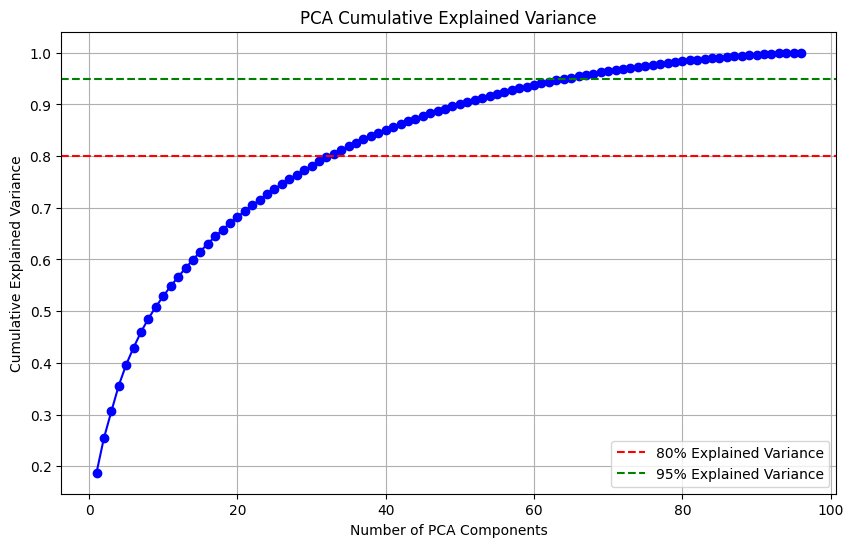

In [38]:
# Step 1: Function to compute cumulative variance for PCA components
def plot_pca_cumulative_variance(embeddings):
    # Perform PCA without specifying n_components to get the full spectrum
    pca = PCA()
    pca.fit(embeddings)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Plot cumulative variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='b')
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA Cumulative Explained Variance")
    plt.grid(True)
    plt.axhline(y=0.8, color='r', linestyle='--', label="80% Explained Variance")
    plt.axhline(y=0.95, color='g', linestyle='--', label="95% Explained Variance")
    plt.legend()
    plt.show()

# Step 2: Call function to plot cumulative variance
plot_pca_cumulative_variance(embeddings)

We have found out that 40 components explain more than 80% of our data.

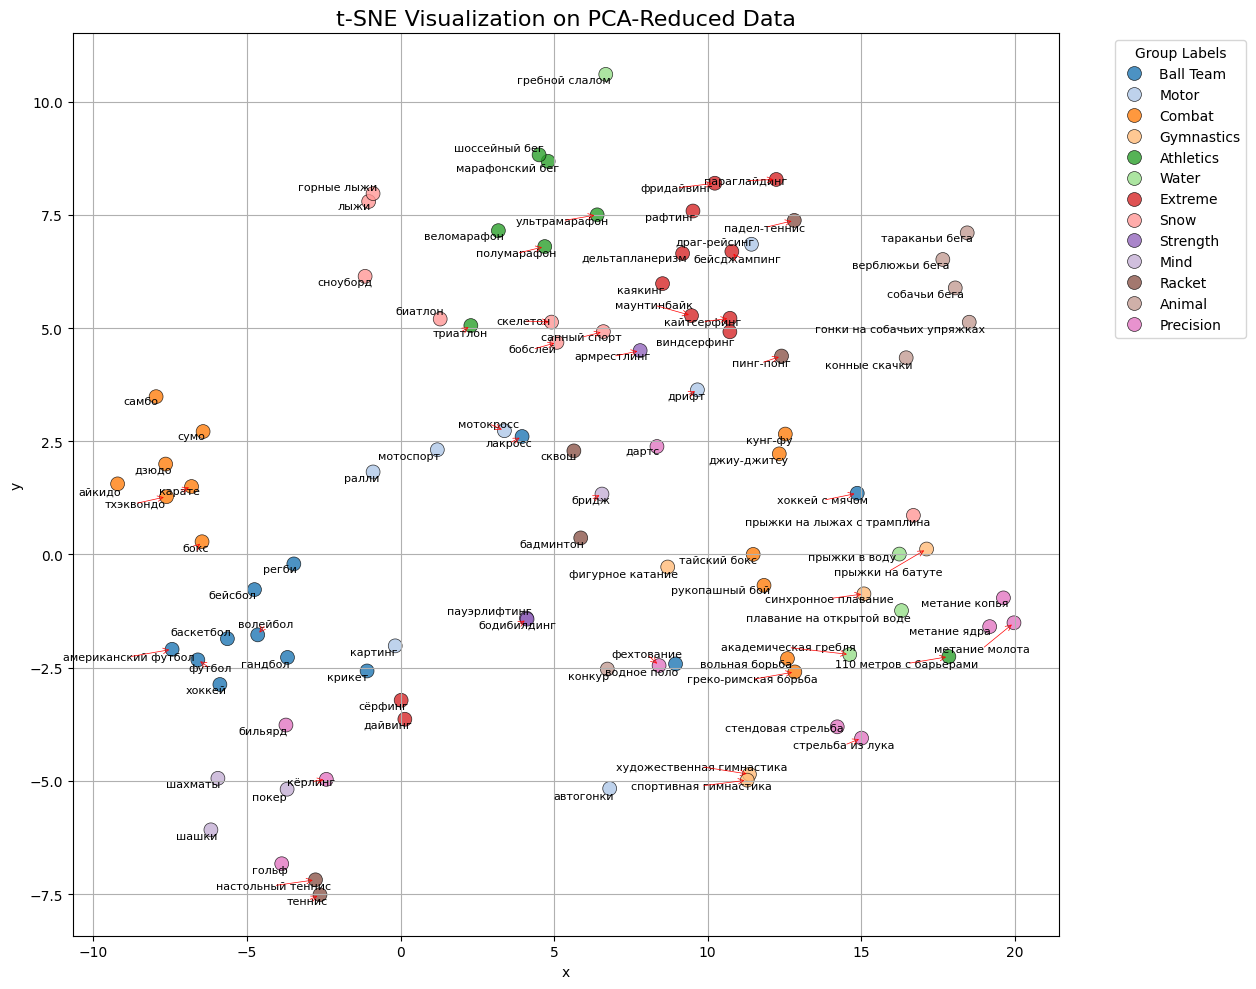

In [39]:
# Step 1: Apply PCA to reduce to 40 components
def apply_pca(embeddings, n_components=40):
    pca = PCA(n_components=n_components, random_state=42)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings

# Step 2: Apply t-SNE on PCA-reduced data
def apply_tsne(reduced_embeddings, labels, words):
    # Set perplexity as a function of sample size for optimal t-SNE performance
    perplexity = min(30, max(5, int(reduced_embeddings.shape[0] / 5)))  # Adjusted for more typical usage
    tsne = TSNE(n_components=2, random_state=7, perplexity=perplexity)
    tsne_embeddings = tsne.fit_transform(reduced_embeddings)

    # Create a DataFrame for plotting
    df = pd.DataFrame({
        'x': tsne_embeddings[:, 0],
        'y': tsne_embeddings[:, 1],
        'label': labels,
        'word': words
    })

    # Plot using seaborn
    plt.figure(figsize=(15, 10))
    plot = sns.scatterplot(data=df, x='x', y='y', hue='label', s=100, palette="tab20", alpha=0.8, edgecolor="k", linewidth=0.5)

    # Initialize text annotations and optimize to reduce overlap using adjust_text
    texts = []
    for i, row in df.iterrows():
        # Annotate the label at the point position with a small offset to avoid overlap
        texts.append(plt.text(row['x'], row['y'], row['word'], fontsize=8, ha='right', va='top'))

    # Use adjust_text to automatically adjust text positions
    adjust_text(texts, expand_points=(1.2, 1.2), arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

    plt.title("t-SNE Visualization on PCA-Reduced Data", fontsize=16)
    # Move legend to the right side of the plot
    plt.legend(title="Group Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout(rect=[0,0,0.85,1])  # Adjust the rect parameter as needed to fit the legend outside the plot
    plt.show()

reduced_embeddings_pca = apply_pca(embeddings, n_components=40)
apply_tsne(reduced_embeddings_pca, labels, valid_words)


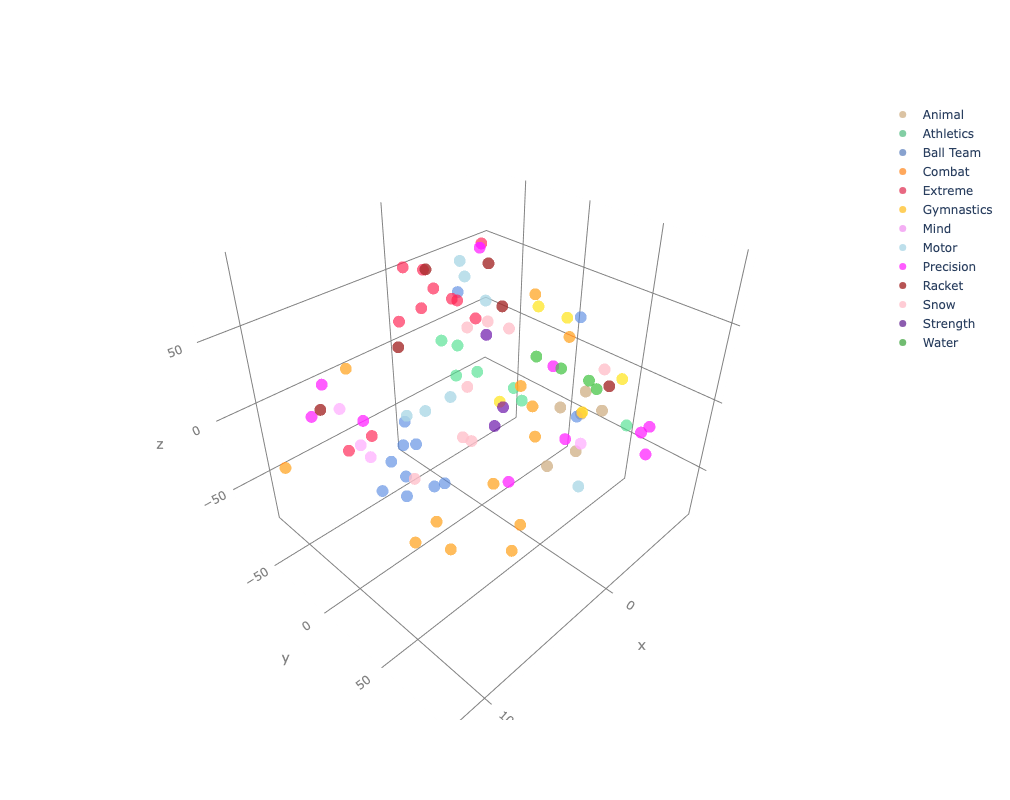

In [40]:
perplexity = min(5, reduced_embeddings_pca.shape[0] - 1)
tsne = TSNE(n_components=3, random_state=7, perplexity=perplexity)
tsne_embeddings = tsne.fit_transform(reduced_embeddings_pca)

# Creating random 3D vectors and text groups
vectors = tsne_embeddings
groups = np.array(labels)
words = valid_words

# Setting a list of 13 stable colors
colors = [
    'rgba(210, 180, 140, 1)',    # beige
    'rgba(60, 179, 113, 0.8)',   # Medium Sea Green
    'rgba(70, 110, 180, 0.8)',   # Steel Blue
    'rgba(255, 120, 0, 0.8)',    # Dark Orange
    'rgba(220, 20, 60, 0.8)',    # Crimson
    'rgba(255, 180, 0, 0.8)',    # Orange
    'rgba(238, 130, 238, 0.8)',  # Violet
    'rgba(173, 216, 230, 1)',    # Light Blue
    'rgba(255, 0, 255, 0.8)',      # Fuchsia
    'rgba(165, 42, 42, 1)',      # Brown
    'rgba(255, 192, 203, 1)',    # Medium Purple
    'rgba(75, 0, 130, 0.8)',     # Pink
    'rgba(34, 150, 34, 0.8)'     # Forest Green
]

fig = go.Figure()

# Adding a separate trace for each group with a unique color
for i, group in enumerate(np.unique(groups)):
    # Selecting the indices of the points that belong to this group
    indices = np.where(groups == group)[0]  # Indexes for each group

    fig.add_trace(go.Scatter3d(
        x=vectors[indices, 0],
        y=vectors[indices, 1],
        z=vectors[indices, 2],
        mode='markers',
        marker=dict(
            size=7,
            color=colors[i],  # Using a fixed color for each group
            opacity=0.8
        ),
        text=[words[j] for j in indices],
        name=group,
        hoverinfo='text'
    ))

# Increasing the size of the graph
fig.update_layout(plot_bgcolor='black',
    width=1000,
    height=800,
    scene=dict(
      xaxis=dict(nticks=4, range=[min(vectors[:, 0]), max(vectors[:, 0])],
                             backgroundcolor="white",
            color="grey",
            gridcolor="grey",
            showbackground=True,
            zerolinecolor="grey"),
      yaxis=dict(nticks=4, range=[min(vectors[:, 1]), max(vectors[:, 1])],
                             backgroundcolor="white",
            color="grey",
            gridcolor="grey",
            showbackground=True,
            zerolinecolor="grey"),
      zaxis=dict(nticks=4, range=[min(vectors[:, 2]), max(vectors[:, 2])],
                             backgroundcolor="white",
            color="grey",
            gridcolor="grey",
            showbackground=True,
            zerolinecolor="grey"),
    )
)

fig.show()

fig.write_html("3d_plot.html")

**Some observations**

Ball team sports (football, hockey) are close, artistic and combat sports are also together, but racket sports are far away.
Embeddings’ sensitivity to subword similarities leads to unexpected semantic closeness: лакросс (lacrosse) and мотокросс (motocross) or пинг-понг (ping pong) is close to кунг-фу (kung fu).
Grouping of прыжки в воду (diving), прыжки на батуте (trampoline jumping) and прыжки на лыжах с трамплина (ski jumping) together. It is either due to the common root or to involvement of aerial maneuvers, balance and coordination.
Synonyms as пинг-понг (ping pong) and настольный теннис (table tennis) appear far apart. It’s maybe due to their frequencies or contexts.
Tennis and golf may be near because of the association with higher socio-economic status.
Our hypothesis was generally confirmed, as sports seem to mostly group on the basis of shared competition principles. However, we made an attempt to create more precise classification with the help of clustering algorythm. This attempt will also serve well in checking whether larger number of dimensions will be more efficient in defining classes.

**K-means Clustering**

Method 1 for finding optimal number of clusters: Elbow Method

We iterate through the different possible values of K and observe the WCSS (Within Cluster Sum of Squares) or inertia. When increasing K doesn't improve (decrease) the WCSS a lot, this is an indicator of an 'optimal' K, where it looks like and 'elbow'.

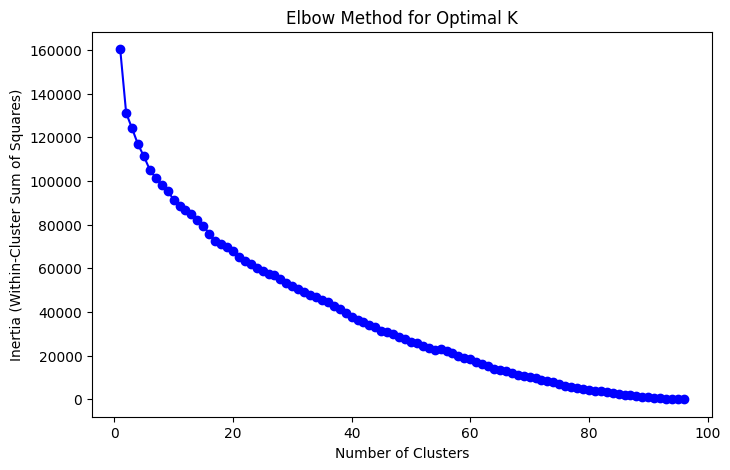

In [41]:
from sklearn.cluster import KMeans

# Step 1: Elbow Method to Determine Optimal Number of Clusters
def elbow_method(reduced_embeddings_pca, max_clusters=96):
    inertia = []
    cluster_range = range(1, max_clusters + 1)
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(reduced_embeddings_pca)
        inertia.append(kmeans.inertia_)

    # Plotting the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(cluster_range, inertia, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
    plt.title("Elbow Method for Optimal K")
    plt.show()

# Run the elbow method on PCA-reduced embeddings
elbow_method(reduced_embeddings_pca, max_clusters=96)

**Method 2 for finding optimal number of clusters: Silhouette Score**

ALternative or complementary approach for determining the optimal K. It measures how similar a data point is to its own cluster (cohesion) compared to other clusters (separation). Its value ranges from -1 to 1.

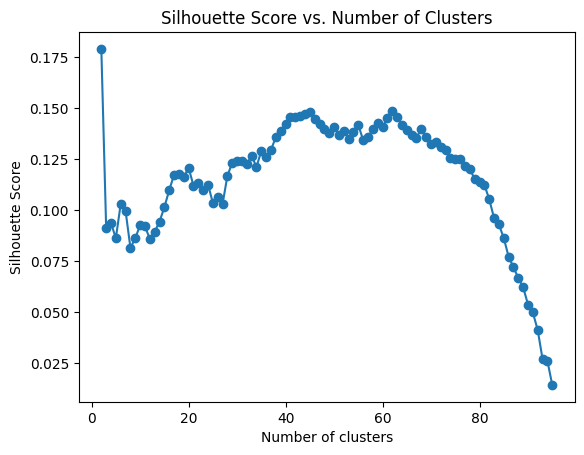

In [42]:
from sklearn.metrics import silhouette_score

# Range of clusters to check
range_n_clusters = list(range(2, 96))

sil_scores = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reduced_embeddings_pca)
    score = silhouette_score(reduced_embeddings_pca, kmeans.labels_)
    sil_scores.append(score)

# Plot the silhouette scores to choose the optimal number of clusters
plt.plot(range_n_clusters, sil_scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.show()


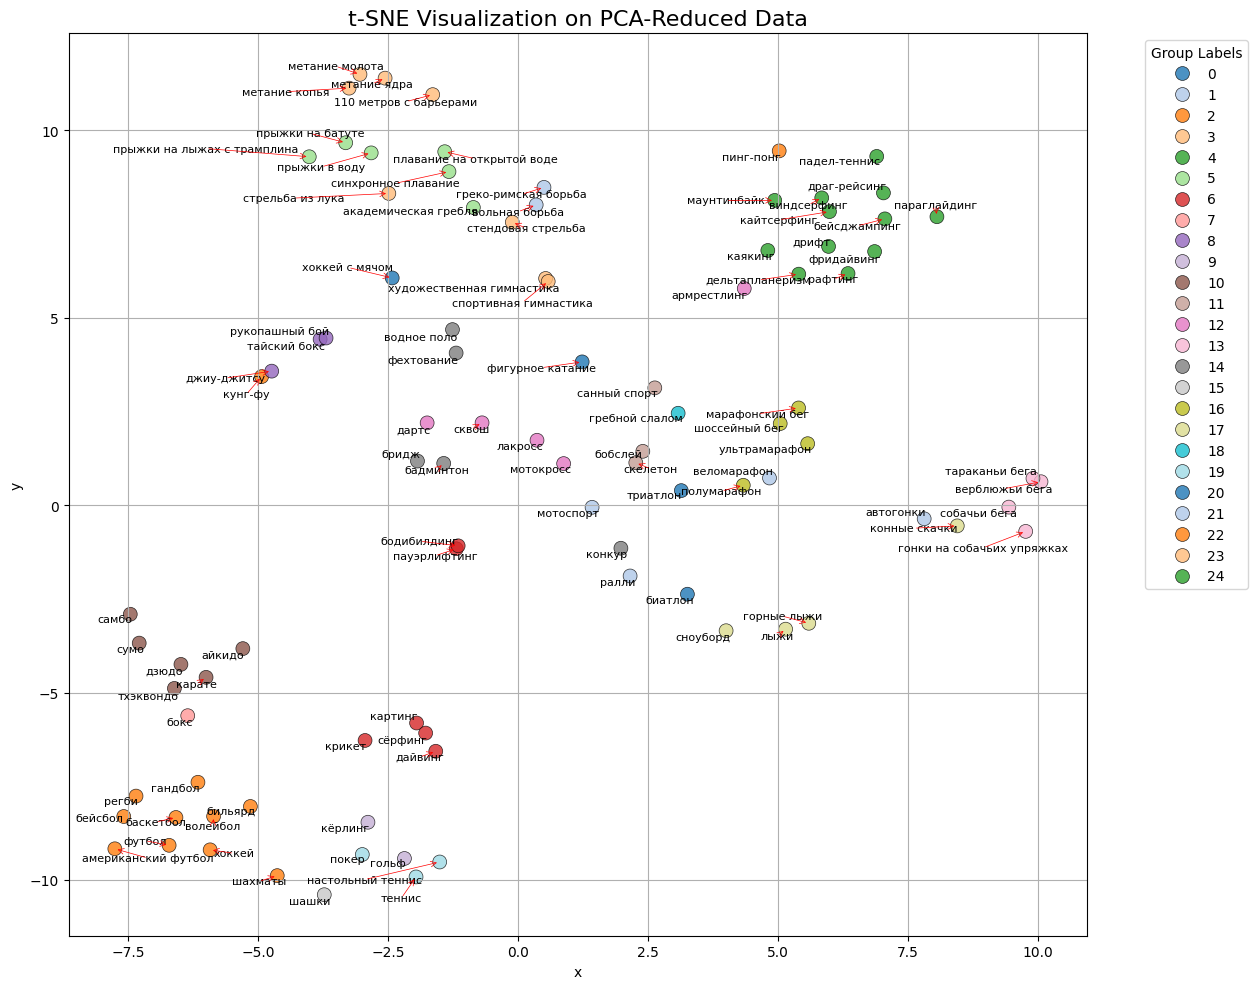

In [43]:
# Perform KMeans clustering on the reduced embeddings
kmeans = KMeans(n_clusters=25, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings_pca)

reduced_embeddings_pca = apply_pca(reduced_embeddings_pca, n_components=10)
reduced_embeddings_tsne=apply_tsne(reduced_embeddings_pca, clusters, valid_words)

**Autoencoder for dimensionality reduction**

In this section, we tried to use an autoencoder to reduce the dimensionality of the dataset by capturing the most relevant features and denoising the dataset. This autoencoder uses a neural network to reduce the dimensionality of embeddings from 768 to 64, with the aim of improving clustering by capturing the most important features while removing noise.

Architecture:

Input Layer: Matches the dimensionality of the embeddings.
Compresses the data into a lower-dimensional space with two dense layers (128 and 64 neurons) and Dropout (10%) to prevent overfitting.
Training: Optimized with MSE loss and early stopping to prevent overfitting.

In [44]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random

# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)


# Define and train the autoencoder with dropout
input_layer = Input(shape=(embeddings.shape[1],))  # Shape of original embeddings
encoded = Dense(128, activation='relu')(input_layer)  # Encoder layer
encoded = Dropout(0.1)(encoded)  # Dropout layer (30% dropout)
encoded = Dense(64, activation='relu')(encoded)  # Encoder layer with more neurons
encoded = Dropout(0.1)(encoded)  # Dropout layer (30% dropout)
decoded = Dense(64, activation='relu')(encoded)  # Decoder layer
decoded = Dropout(0.1)(decoded)  # Dropout layer (30% dropout)
decoded = Dense(embeddings.shape[1], activation='sigmoid')(decoded)  # Output layer

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the autoencoder with validation split and early stopping
autoencoder.fit(embeddings, embeddings, epochs=1000, batch_size=256, shuffle=True,
                validation_split=0.2, callbacks=[early_stopping])

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 9.7251 - val_loss: 9.5566
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 9.6332 - val_loss: 9.4573
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 9.5330 - val_loss: 9.3423
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 9.4196 - val_loss: 9.2181
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 9.3097 - val_loss: 9.0896
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 9.1704 - val_loss: 8.9641
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 9.0537 - val_loss: 8.8461
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 8.9327 - val_loss: 8.7388
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 8.8268 - val_loss: 8.6448
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.7370 - val_loss: 8.5669
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 8.6465 - val_loss: 8.5055
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 8.5

In [45]:
# Use the encoder part of the autoencoder to reduce dimensionality
encoder = Model(input_layer, encoded)
reduced_embeddings_autoencoder = encoder.predict(embeddings)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [46]:
print("New dimensionality of embeddings:", reduced_embeddings_autoencoder.shape[1])

New dimensionality of embeddings: 64


In the subsequent sections we repeat the previous steps with the reduced embeddings by the autoencoder.

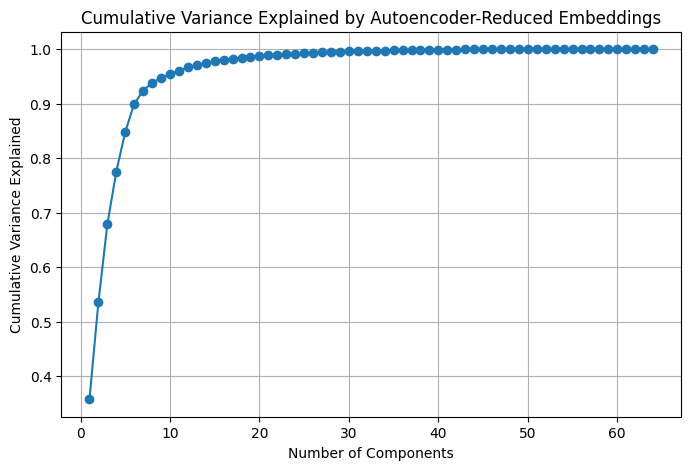

Number of components to capture 80% variance: 5
Number of components to capture 90% variance: 7
Number of components to capture 95% variance: 10


In [47]:
# Apply PCA to the autoencoder-reduced embeddings to find explained variance per component
pca = PCA()
pca.fit(reduced_embeddings_autoencoder)
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Variance Explained by Autoencoder-Reduced Embeddings")
plt.grid()
plt.show()

# Print number of dimensions to capture specific thresholds, e.g., 80%, 90%
for threshold in [0.8, 0.9, 0.95]:
    num_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"Number of components to capture {int(threshold * 100)}% variance: {num_components}")

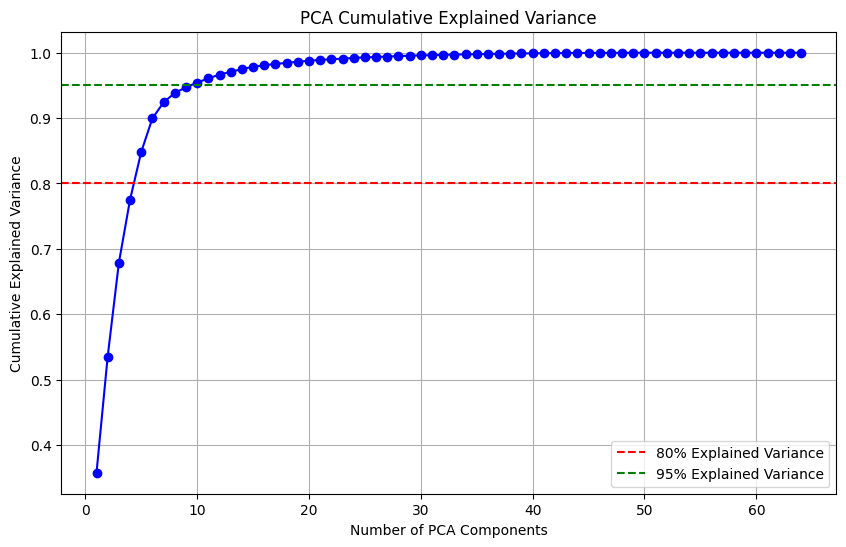

In [48]:
# Call function to plot cumulative variance
plot_pca_cumulative_variance(reduced_embeddings_autoencoder)

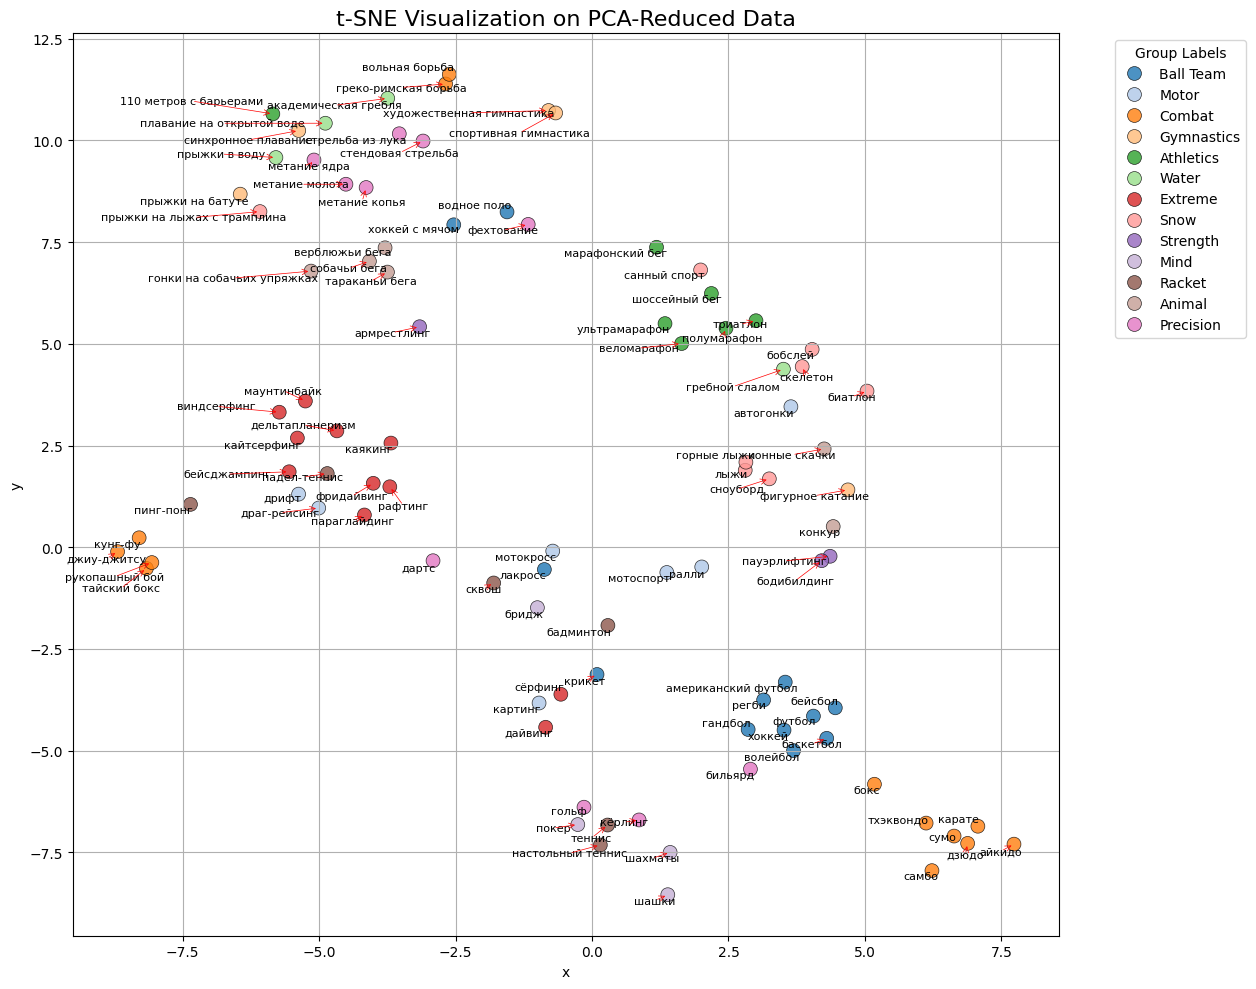

In [49]:
# Run PCA to reduce embeddings, then t-SNE for visualization
reduced_embeddings_pca = apply_pca(reduced_embeddings_autoencoder, n_components=10)
reduced_embeddings_tsne=apply_tsne(reduced_embeddings_pca, labels, valid_words)

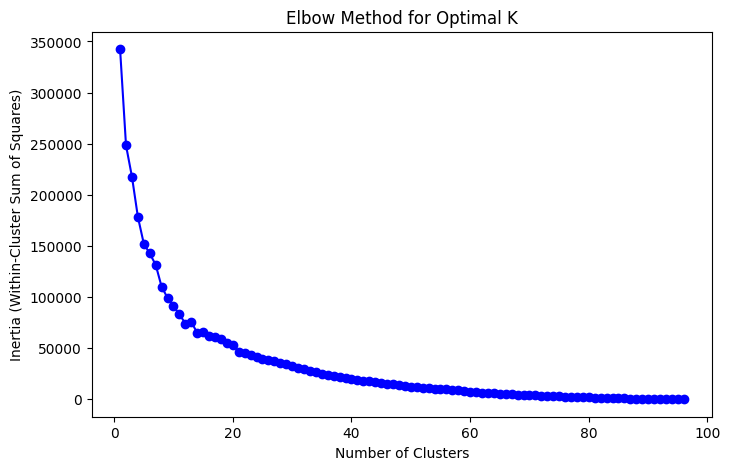

In [50]:
# Elbow Method to Determine Optimal Number of Clusters
def elbow_method(data, max_clusters=96):
    inertia = []
    cluster_range = range(1, max_clusters + 1)

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=100)
        kmeans.fit(reduced_embeddings_autoencoder)
        inertia.append(kmeans.inertia_)

    # Plotting the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(cluster_range, inertia, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
    plt.title("Elbow Method for Optimal K")
    plt.show()

# Run the elbow method on PCA-reduced embeddings
elbow_method(reduced_embeddings_pca, max_clusters=96)

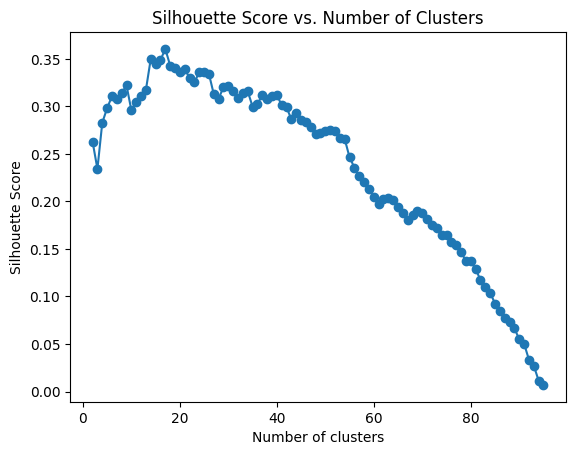

In [51]:
from sklearn.metrics import silhouette_score
# Range of clusters to check
range_n_clusters = list(range(2, 96))

sil_scores = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reduced_embeddings_pca)
    score = silhouette_score(reduced_embeddings_pca, kmeans.labels_)
    sil_scores.append(score)

# Plot the silhouette scores to choose the optimal number of clusters
plt.plot(range_n_clusters, sil_scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.show()

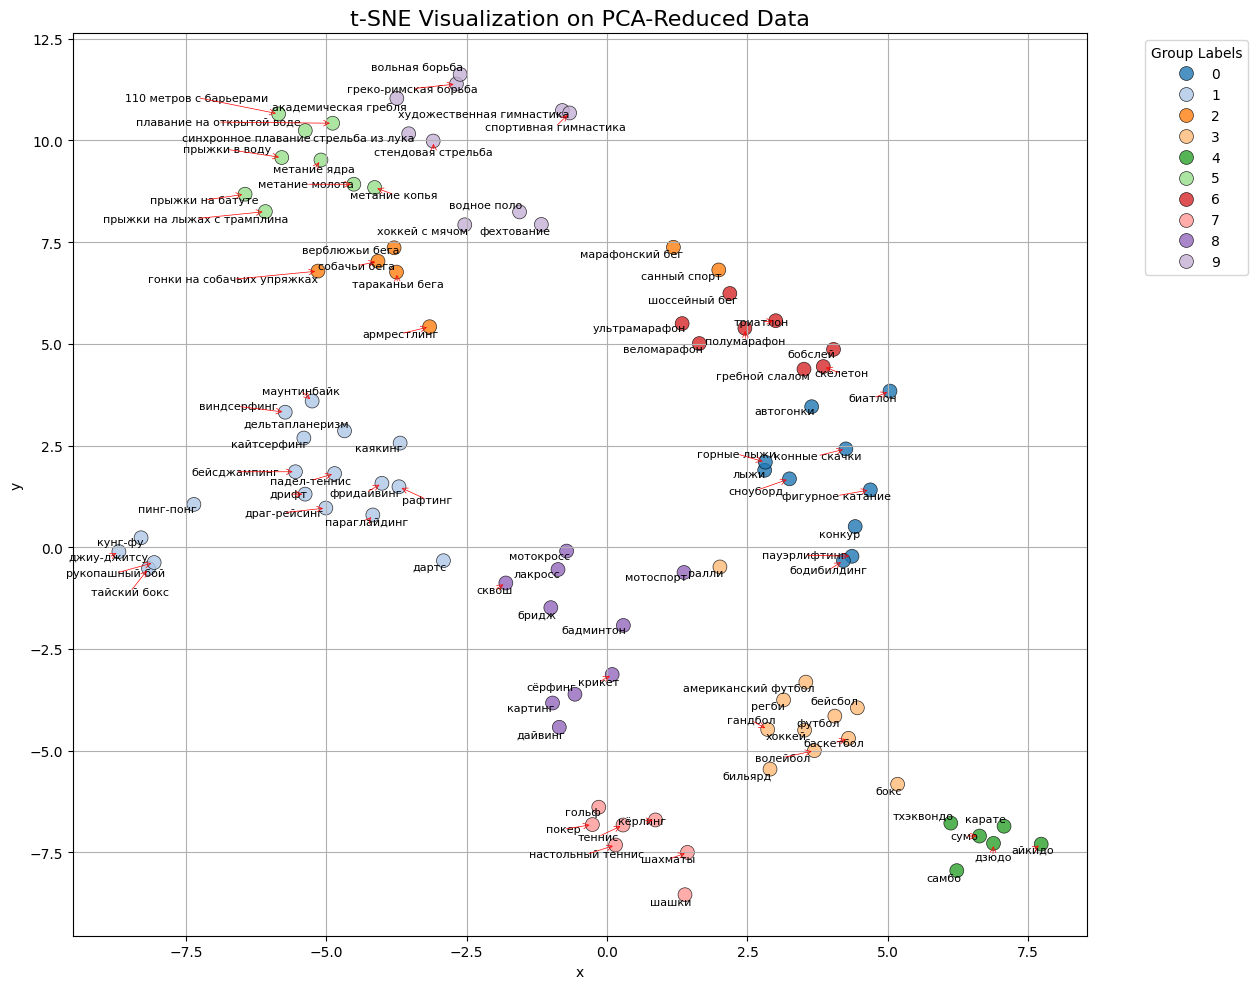

In [52]:
# Perform KMeans clustering on the reduced embeddings
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings_autoencoder)

reduced_embeddings_pca = apply_pca(reduced_embeddings_autoencoder, n_components=10)
reduced_embeddings_tsne=apply_tsne(reduced_embeddings_pca, clusters, valid_words)

**Conclusions**
In support of our hypothesis, embeddings for sports names tend to group based on an integrated representation of their competition format, rules, and scoring/assessment systems.

Beyond capturing the mechanics specific to certain sports, embeddings may also reflect sociocultural aspects.

As BERT is trained on subwords, some out-of-dictionary words may still be projected in the embedding space based only on their morphological components. BERT enables the use of context for more accurate disambiguation of polysemous words (e.g., 'бокс' meaning 'boxing').

Embeddings often disregard specific equipment, causing racket sports like ping pong, tennis, and badminton to be positioned far apart from each other and football and hockey to come near.

The quality of clustering depends on the overall accuracy of the embeddings, which may lack the specificity needed to effectively classify sports names.

Dimensionality reduction with autoencoder improves separation and clustering results.

Despite these efforts, achieving effective clustering remains challenging due to the limited amount of data available for high-dimensional embeddings (just 100 sports in a 768-dimensional space).

Accurate and exclusive classification of sports names remains an open question, as sports often share multiple features across different groups, making it difficult to define the governing factor. This is aligned with the difficulty of performing a comprehensive clustering.